In [1]:
# Import packages
import pandas as pd
import geopandas as gpd
import numpy as np
import rdrobust as rd
import matplotlib.pyplot as plt

# Load data
sales_df = pd.read_csv("sales_values.csv") # sales values data
oa_gdf = gpd.read_file("London_OA_2016.shp") # opportunity areas shapefile

# Filter data for year 2022 and convert to geodataframe
sales_df = sales_df[sales_df["Year"] == 2022]
sales_gdf = gpd.GeoDataFrame(sales_df, geometry=gpd.points_from_xy(sales_df["Longitude"], sales_df["Latitude"]))

# Spatial join sales data with opportunity areas data
sales_gdf = gpd.sjoin(sales_gdf, oa_gdf, how="left", op="within")

# Define treatment indicator variable
sales_gdf["treatment"] = sales_gdf["index_right"].notnull().astype(int)

# Define running variable as distance to nearest opportunity area boundary
sales_gdf["distance"] = sales_gdf.geometry.apply(lambda x: oa_gdf.boundary.distance(x).min())

# Choose bandwidth using rdrobust.bandwidth
bw_result = rd.rdrobust.bandwidth(sales_gdf["Sales_Value"], sales_gdf["distance"], sales_gdf["treatment"], c=0)
bw = bw_result.bw

# Filter data for observations within bandwidth
sales_gdf = sales_gdf[sales_gdf["distance"].abs() <= bw]

# Estimate effect using rdrobust
rd_result = rd.rdrobust(sales_gdf["Sales_Value"], sales_gdf["distance"], sales_gdf["treatment"], c=0)

# Print results
print(rd_result.summary)

# Plot results
rd.plot(rd_result)
plt.show()

ModuleNotFoundError: No module named 'rdrobust'

In [ ]:
pip install rdrobust

In [2]:
# Import packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
openuprncsv = pd.read_csv("data/osopenuprn_202302.csv")
openuprncsv.head()

UPRN  X_COORDINATE  Y_COORDINATE   LATITUDE  LONGITUDE
0     1     358260.66      172796.5  51.452601  -2.602075
1    26     352967.00      181077.0  51.526633  -2.679361
2    27     352967.00      181077.0  51.526633  -2.679361
3    30     354800.00      180469.0  51.521317  -2.652862
4    31     354796.00      180460.0  51.521236  -2.652918

In [4]:
openuprncsv = openuprncsv[(openuprncsv['X_COORDINATE'] > 490000) & (openuprncsv['X_COORDINATE'] < 570000) & (openuprncsv['Y_COORDINATE'] > 150000) & (openuprncsv['Y_COORDINATE'] < 210000)]
openuprncsv.describe()

UPRN  X_COORDINATE  Y_COORDINATE      LATITUDE     LONGITUDE
count  6.722480e+06  6.722480e+06  6.722480e+06  6.722480e+06  6.722480e+06
mean   5.268968e+10  5.293313e+05  1.804992e+05  5.150843e+01 -1.377609e-01
std    5.755553e+10  1.513976e+04  1.129795e+04  1.014284e-01  2.182612e-01
min    5.000001e+06  4.900002e+05  1.500002e+05  5.122399e+01 -7.118276e-01
25%    2.071048e+08  5.204650e+05  1.737860e+05  5.144663e+01 -2.656588e-01
50%    1.009169e+10  5.300240e+05  1.808250e+05  5.151192e+01 -1.282248e-01
75%    1.000226e+11  5.377630e+05  1.870530e+05  5.156638e+01 -1.603860e-02
max    2.000047e+11  5.699996e+05  2.100000e+05  5.178083e+01  4.617771e-01

<AxesSubplot:>

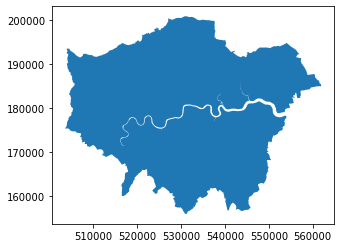

In [7]:
boros = gpd.read_file("data/boros/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union)).rename(columns={0:'geometry'})
ldn = ldn.set_crs(epsg=27700)
ldn.plot()

In [8]:
openuprn2 = gpd.GeoDataFrame(openuprncsv, geometry = gpd.points_from_xy(openuprncsv['X_COORDINATE'], openuprncsv['Y_COORDINATE']), crs = 'EPSG:27700')
openuprn2.head()

UPRN  X_COORDINATE  Y_COORDINATE   LATITUDE  LONGITUDE  \
431563  5000001      528240.0      185465.0  51.553508  -0.151684   
431564  5000002      528256.0      186364.0  51.561583  -0.151126   
431565  5000003      528256.0      186364.0  51.561583  -0.151126   
431566  5000004      528256.0      186364.0  51.561583  -0.151126   
431567  5000005      528256.0      186364.0  51.561583  -0.151126   

                             geometry  
431563  POINT (528240.000 185465.000)  
431564  POINT (528256.000 186364.000)  
431565  POINT (528256.000 186364.000)  
431566  POINT (528256.000 186364.000)  
431567  POINT (528256.000 186364.000)

In [76]:
uprn_ldn = gpd.sjoin(openuprn2, ldn, predicate='within', how='inner')
uprn_ldn.head(2)

UPRN  X_COORDINATE  Y_COORDINATE   LATITUDE  LONGITUDE  \
431563  5000001      528240.0      185465.0  51.553508  -0.151684   
431564  5000002      528256.0      186364.0  51.561583  -0.151126   

                             geometry  index_right  
431563  POINT (528240.000 185465.000)            0  
431564  POINT (528256.000 186364.000)            0

In [14]:
uprnlookup = pd.read_csv("data/ppdiduprnusrnubdc.csv")
uprnlookup.head()

transactionid  uprn     usrn
0  {DD204FA6-B333-4A06-9E31-7ACABE162EB7}    30  4549897
1  {B26F0F8D-4C7A-4DBF-B10A-3336830BF462}    31  4549897
2  {241A4A53-DD8C-706B-E050-A8C06205638B}    63  4582546
3  {85866A64-627D-143F-E053-6B04A8C06A15}    97  4527985
4  {BE61D947-ED06-482E-8274-8B84912C15CB}   103  4527985

In [77]:
uprn = pd.merge(uprn_ldn, uprnlookup, how = 'left', left_on = 'UPRN', right_on = 'uprn')
uprn.head()

UPRN  X_COORDINATE  Y_COORDINATE   LATITUDE  LONGITUDE  \
0  5000001      528240.0      185465.0  51.553508  -0.151684   
1  5000002      528256.0      186364.0  51.561583  -0.151126   
2  5000003      528256.0      186364.0  51.561583  -0.151126   
3  5000003      528256.0      186364.0  51.561583  -0.151126   
4  5000004      528256.0      186364.0  51.561583  -0.151126   

                        geometry  index_right  \
0  POINT (528240.000 185465.000)            0   
1  POINT (528256.000 186364.000)            0   
2  POINT (528256.000 186364.000)            0   
3  POINT (528256.000 186364.000)            0   
4  POINT (528256.000 186364.000)            0   

                            transactionid       uprn        usrn  
0                                     NaN        NaN         NaN  
1  {1DE03ED3-FFE7-44D8-9F7D-2E1F7AEF2009}  5000002.0  20400012.0  
2  {ACFAC31D-982C-42E5-8B4F-0CFAD8F687FA}  5000003.0  20400012.0  
3  {A2479555-79F5-74C7-E053-6B04A8C0887D}  5000003.0  20400012.0  
4  {E8D3BA46-35F2-49F9-952D-685755233C2E}  5000004.0  20400012.0

In [16]:
uprn['uprn'].info()

<class 'pandas.core.series.Series'>
Int64Index: 5274441 entries, 0 to 5274440
Series name: uprn
Non-Null Count   Dtype  
--------------   -----  
288743 non-null  float64
dtypes: float64(1)
memory usage: 80.5 MB


In [78]:
#dropping NAs here to only include properties that we have a transaction id for - this is a big destructive step
uprn = uprn[['UPRN', 'geometry', 'transactionid', 'usrn']]
uprn.head()

UPRN                       geometry  \
0  5000001  POINT (528240.000 185465.000)   
1  5000002  POINT (528256.000 186364.000)   
2  5000003  POINT (528256.000 186364.000)   
3  5000003  POINT (528256.000 186364.000)   
4  5000004  POINT (528256.000 186364.000)   

                            transactionid        usrn  
0                                     NaN         NaN  
1  {1DE03ED3-FFE7-44D8-9F7D-2E1F7AEF2009}  20400012.0  
2  {ACFAC31D-982C-42E5-8B4F-0CFAD8F687FA}  20400012.0  
3  {A2479555-79F5-74C7-E053-6B04A8C0887D}  20400012.0  
4  {E8D3BA46-35F2-49F9-952D-685755233C2E}  20400012.0

In [79]:
folder_path = 'data/hpm_la_2022/london/'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

dfs = []
for csv_file in csv_files:
    df = pd.read_csv(os.path.join(folder_path, csv_file))
    dfs.append(df)

price = pd.concat(dfs)

In [75]:
price['lad21cd'].unique()

array(['E09000002', 'E09000003', 'E09000004', 'E09000005', 'E09000006',
       'E09000007', 'E09000001', 'E09000008', 'E09000009', 'E09000010',
       'E09000011', 'E09000012', 'E09000013', 'E09000014', 'E09000015',
       'E09000016', 'E09000017', 'E09000018', 'E09000019', 'E09000020',
       'E09000021', 'E09000022', 'E09000023', 'E09000024', 'E09000025',
       'E09000026', 'E09000027', 'E09000028', 'E09000029', 'E09000030',
       'E09000031', 'E09000032', 'E09000033'], dtype=object)

In [80]:
price_merge = pd.merge(price, uprn, how = 'left', left_on = "transactionid", right_on = "transactionid")

price_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2530661 entries, 0 to 2530660
Data columns (total 19 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   priceper                     float64 
 1   year                         int64   
 2   dateoftransfer               object  
 3   propertytype                 object  
 4   duration                     object  
 5   price                        int64   
 6   postcode                     object  
 7   lad21cd                      object  
 8   transactionid                object  
 9   id                           int64   
 10  tfarea                       float64 
 11  numberrooms                  float64 
 12  classt                       int64   
 13  CURRENT_ENERGY_EFFICIENCY    int64   
 14  POTENTIAL_ENERGY_EFFICIENCY  int64   
 15  CONSTRUCTION_AGE_BAND        object  
 16  UPRN                         float64 
 17  geometry                     geometry
 18  usrn                  

In [30]:
#rethink this - just do on cols for priceper and uprn maybe?
#price_merge = price_merge.dropna()
price_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195535 entries, 233484 to 2234302
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   priceper                     195535 non-null  float64 
 1   year                         195535 non-null  int64   
 2   dateoftransfer               195535 non-null  object  
 3   propertytype                 195535 non-null  object  
 4   duration                     195535 non-null  object  
 5   price                        195535 non-null  int64   
 6   postcode                     195535 non-null  object  
 7   lad21cd                      195535 non-null  object  
 8   transactionid                195535 non-null  object  
 9   id                           195535 non-null  int64   
 10  tfarea                       195535 non-null  float64 
 11  numberrooms                  195535 non-null  float64 
 12  classt                       195535 no

In [81]:
price_merge.head()

priceper  year dateoftransfer propertytype duration   price  postcode  \
0  4069.767442  2020     2020-05-22            F        L  350000  IG11 0AB   
1  4818.181818  2020     2020-08-06            F        L  265000  IG11 0AB   
2  3837.209302  2020     2020-03-27            F        L  330000  IG11 0AB   
3  4050.632911  2021     2021-01-29            F        L  320000  IG11 0AB   
4  4010.989011  2020     2020-03-27            F        L  365000  IG11 0AB   

     lad21cd                           transactionid        id  tfarea  \
0  E09000002  {BA558B33-27A3-76EF-E053-6B04A8C0B4B7}  18447501    86.0   
1  E09000002  {BA558B33-2824-76EF-E053-6B04A8C0B4B7}  18504360    55.0   
2  E09000002  {CB0035E6-46A2-58AE-E053-6B04A8C091AF}  18466498    86.0   
3  E09000002  {C3C3F9B6-6007-362B-E053-6B04A8C03ACC}  18479494    79.0   
4  E09000002  {BA558B33-2773-76EF-E053-6B04A8C0B4B7}  18493931    91.0   

   numberrooms  classt  CURRENT_ENERGY_EFFICIENCY  \
0          NaN      11                         83   
1          NaN      11                         83   
2          NaN      11                         84   
3          NaN      11                         83   
4          NaN      11                         83   

   POTENTIAL_ENERGY_EFFICIENCY CONSTRUCTION_AGE_BAND  UPRN geometry  usrn  
0                           83              NO DATA!   NaN     None   NaN  
1                           83              NO DATA!   NaN     None   NaN  
2                           84              NO DATA!   NaN     None   NaN  
3                           83              NO DATA!   NaN     None   NaN  
4                           83              NO DATA!   NaN     None   NaN

In [83]:
price_merge['UPRN'].info()

<class 'pandas.core.series.Series'>
Int64Index: 2530661 entries, 0 to 2530660
Series name: UPRN
Non-Null Count   Dtype  
--------------   -----  
222104 non-null  float64
dtypes: float64(1)
memory usage: 38.6 MB


In [84]:
price_merge = price_merge.set_geometry('geometry')


In [85]:
sales_gdf = price_merge.copy()
sales_gdf.head()

priceper  year dateoftransfer propertytype duration   price  postcode  \
0  4069.767442  2020     2020-05-22            F        L  350000  IG11 0AB   
1  4818.181818  2020     2020-08-06            F        L  265000  IG11 0AB   
2  3837.209302  2020     2020-03-27            F        L  330000  IG11 0AB   
3  4050.632911  2021     2021-01-29            F        L  320000  IG11 0AB   
4  4010.989011  2020     2020-03-27            F        L  365000  IG11 0AB   

     lad21cd                           transactionid        id  tfarea  \
0  E09000002  {BA558B33-27A3-76EF-E053-6B04A8C0B4B7}  18447501    86.0   
1  E09000002  {BA558B33-2824-76EF-E053-6B04A8C0B4B7}  18504360    55.0   
2  E09000002  {CB0035E6-46A2-58AE-E053-6B04A8C091AF}  18466498    86.0   
3  E09000002  {C3C3F9B6-6007-362B-E053-6B04A8C03ACC}  18479494    79.0   
4  E09000002  {BA558B33-2773-76EF-E053-6B04A8C0B4B7}  18493931    91.0   

   numberrooms  classt  CURRENT_ENERGY_EFFICIENCY  \
0          NaN      11                         83   
1          NaN      11                         83   
2          NaN      11                         84   
3          NaN      11                         83   
4          NaN      11                         83   

   POTENTIAL_ENERGY_EFFICIENCY CONSTRUCTION_AGE_BAND  UPRN geometry  usrn  
0                           83              NO DATA!   NaN     None   NaN  
1                           83              NO DATA!   NaN     None   NaN  
2                           84              NO DATA!   NaN     None   NaN  
3                           83              NO DATA!   NaN     None   NaN  
4                           83              NO DATA!   NaN     None   NaN

In [89]:
sales_gdf = sales_gdf.dropna(subset = ['geometry'])

In [90]:
sales_gdf['lad21cd'].unique()

array(['E09000003', 'E09000005', 'E09000007', 'E09000001', 'E09000009',
       'E09000013', 'E09000015', 'E09000017', 'E09000018', 'E09000030'],
      dtype=object)

In [91]:
oa_gdf = gpd.read_file("data/oa/Opportunity_Areas/Opportunity_Areas.shp")
oa_gdf.head()

objectid   layerrefer siterefere                             sitename  \
0         1  OPA00000001         21  Bankside, Borough and London Bridge   
1         2  OPA00000002         11                  Elephant and Castle   
2         3  OPA00000003          8                              Croydon   
3         4  OPA00000004         12                               Euston   
4         5  OPA00000005         37                           White City   

  address  uprn                 borough planning_a firstadded lastupdate  ...  \
0    None     0               Southwark       None       None       None  ...   
1    None     0               Southwark       None       None       None  ...   
2    None     0                 Croydon       None       None       None  ...   
3    None     0                  Camden       None       None       None  ...   
4    None     0  Hammersmith and Fulham       None       None       None  ...   

         designatio boroughdes  classifica  \
0  Opportunity Area       None        None   
1  Opportunity Area       None        None   
2  Opportunity Area       None        None   
3  Opportunity Area       None        None   
4  Opportunity Area       None        None   

                                               notes  \
0  Please note the GLA does not define boundaries...   
1  Please note the GLA does not define boundaries...   
2  Please note the GLA does not define boundaries...   
3  Please note the GLA does not define boundaries...   
4  Please note the GLA does not define boundaries...   

                                              source  \
0  https://geo.southwark.gov.uk/connect/analyst/m...   
1  https://www.southwark.gov.uk/planning-and-buil...   
2  https://www.croydon.gov.uk/sites/default/files...   
3  https://www.eustonareaplan.info/wp-content/upl...   
4  https://www.lbhf.gov.uk/planning/regeneration-...   

                          extrainfo1  \
0  document type: Neighbourhood Plan   
1          document type: SPD / OAPF   
2                document type: OAPF   
3           document type: Area Plan   
4                document type: OAPF   

                                          extrainfo2             extrainfo3  \
0  https://www.london.gov.uk/what-we-do/planning/...      Adopted date:2015   
1  https://www.london.gov.uk/what-we-do/planning/...      Adopted date:2015   
2  https://www.london.gov.uk/what-we-do/planning/...  Adopted date:20130101   
3  https://www.london.gov.uk/what-we-do/planning/...  Adopted date:20150101   
4  https://www.london.gov.uk/what-we-do/planning/...  Adopted date:20180201   

  missing                                           geometry  
0    None  POLYGON ((531314.000 180683.000, 531361.300 18...  
1    None  POLYGON ((532338.248 177675.881, 532331.932 17...  
2    None  POLYGON ((532022.186 165038.627, 531991.803 16...  
3    None  POLYGON ((528631.297 183519.827, 528615.904 18...  
4    None  POLYGON ((523154.330 180016.258, 523143.370 18...  

[5 rows x 25 columns]

In [92]:
oa_gdf['extrainfo3'] = oa_gdf['extrainfo3'].str.replace('Adopted date:', '')

In [93]:
oa_gdf['extrainfo3'] = pd.to_datetime(oa_gdf['extrainfo3'], infer_datetime_format=True)
oa_gdf['extrainfo3']

0    2015-01-01
1    2015-01-01
2    2013-01-01
3    2015-01-01
4    2018-02-01
5    2014-01-01
6    2004-01-01
7    2015-01-01
8    2015-09-01
9    2016-11-01
10   2015-01-01
11   2014-07-01
12   2014-07-01
13   2015-12-01
14   2013-07-01
15   2012-06-01
16   2005-12-01
17   2018-02-01
18   2013-07-01
19   2015-09-01
20   2014-07-01
21   2011-01-01
22   2015-09-01
23   2014-07-01
24   2015-11-01
25   2009-12-01
26   2011-01-01
27   2018-03-01
28   2019-10-14
Name: extrainfo3, dtype: datetime64[ns]

<AxesSubplot:>

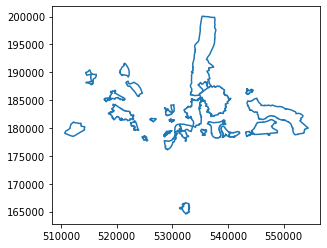

In [38]:
oa_gdf.boundary.plot()

In [29]:
# Spatial join sales_gdf with oa_gdf to find the closest polygon for each point

#oa_gdf['geometry_oa'] = oa_gdf.geometry

# Option 1: Reset the index of oa_gdf before joining
#oa_gdf = oa_gdf.unary_union()

# Spatial join sales_gdf with oa_gdf using geometry as the right geometry column (default)
#sales_gdf = gpd.sjoin(sales_gdf, oa_gdf, how="left", op="intersects", lsuffix="sales", rsuffix="oa")

# Split sales_gdf into two subsets: points inside and outside polygons using geometry_oa
#outside = sales_gdf[~sales_gdf.geometry.within(oa_gdf)]
#inside = sales_gdf[sales_gdf.geometry.within(oa_gdf)]
#inside = sales_gdf[sales_gdf.apply(lambda row: row.geometry_oa.contains(row.geometry) if row.geometry_oa else False, axis=1)].copy()


/opt/conda/lib/python3.10/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/opt/conda/lib/python3.10/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


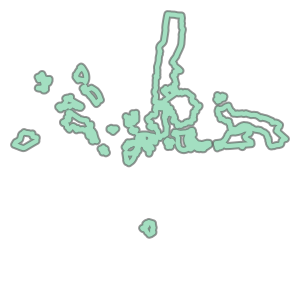

In [94]:
boundary = oa_gdf.boundary.unary_union
buffer = boundary.buffer(500)
buffer

In [73]:
sales_gdf['lad21cd'].unique()

array(['E09000005', 'E09000007', 'E09000001', 'E09000009', 'E09000013',
       'E09000015', 'E09000017', 'E09000018', 'E09000030'], dtype=object)

In [95]:
sales_gdf = sales_gdf[sales_gdf.geometry.within(buffer)]
sales_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 95815 entries, 127197 to 2234886
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   priceper                     95663 non-null  float64 
 1   year                         95815 non-null  int64   
 2   dateoftransfer               95815 non-null  object  
 3   propertytype                 95815 non-null  object  
 4   duration                     95815 non-null  object  
 5   price                        95815 non-null  int64   
 6   postcode                     95815 non-null  object  
 7   lad21cd                      95815 non-null  object  
 8   transactionid                95815 non-null  object  
 9   id                           95815 non-null  int64   
 10  tfarea                       95815 non-null  float64 
 11  numberrooms                  80592 non-null  float64 
 12  classt                       95815 non-null  

In [96]:
# Use sjoin to get points within polygons
points_within = gpd.sjoin(sales_gdf, oa_gdf, op="within")

# Use sjoin to get points outside polygons
points_outside = sales_gdf[~sales_gdf.index.isin(points_within.index)]

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<AxesSubplot:>

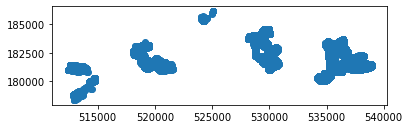

In [97]:
points_outside.plot()

In [67]:
points_within.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 44393 entries, 417028 to 2233922
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   priceper                     44393 non-null  float64 
 1   year                         44393 non-null  int64   
 2   dateoftransfer               44393 non-null  object  
 3   propertytype                 44393 non-null  object  
 4   duration                     44393 non-null  object  
 5   price                        44393 non-null  int64   
 6   postcode                     44393 non-null  object  
 7   lad21cd                      44393 non-null  object  
 8   transactionid                44393 non-null  object  
 9   id                           44393 non-null  int64   
 10  tfarea                       44393 non-null  float64 
 11  numberrooms                  44393 non-null  float64 
 12  classt                       44393 non-null  

<AxesSubplot:>

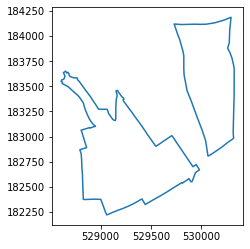

In [60]:
oa_gdf.boundary.plot()

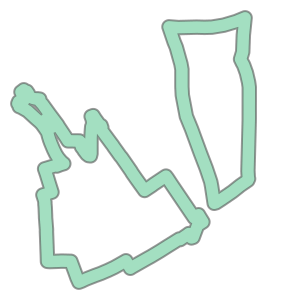

In [75]:
buffer

In [98]:

# Calculate distance from each point to boundary
points_within["distance"] = points_within.geometry.apply(lambda x: x.distance(boundary))
points_outside["distance"] = -points_outside.geometry.apply(lambda x: x.distance(boundary))

# Concatenate subsets back together
result = gpd.GeoDataFrame(pd.concat([points_within, points_outside], ignore_index=True))

result.head()

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


priceper  year dateoftransfer propertytype duration   price postcode  \
0   4179.104478  2020     2020-06-03            F        L  280000  N1C 4AE   
1  11224.489796  2020     2020-10-23            F        L  550000  N1C 4AF   
2   3913.043478  2015     2015-11-27            F        L  180000  N1C 4AF   
3   4533.333333  2019     2019-03-01            F        L  204000  N1C 4AF   
4  11304.347826  2018     2018-10-12            F        L  520000  N1C 4AF   

     lad21cd                           transactionid        id  ...  \
0  E09000007  {AC07BBD0-4B22-0445-E053-6C04A8C01E31}  18985952  ...   
1  E09000007  {B82222ED-16CD-6691-E053-6B04A8C02FB2}  20305424  ...   
2  E09000007  {288DCE29-7919-E510-E050-A8C06205480E}  19052225  ...   
3  E09000007  {85866A65-094D-143F-E053-6B04A8C06A15}  19015919  ...   
4  E09000007  {79A74E21-E549-1289-E053-6B04A8C01627}  19061011  ...   

         designatio  boroughdes  classifica  \
0  Opportunity Area        None        None   
1  Opportunity Area        None        None   
2  Opportunity Area        None        None   
3  Opportunity Area        None        None   
4  Opportunity Area        None        None   

                                               notes  \
0  Please note the GLA does not define boundaries...   
1  Please note the GLA does not define boundaries...   
2  Please note the GLA does not define boundaries...   
3  Please note the GLA does not define boundaries...   
4  Please note the GLA does not define boundaries...   

                                              source  \
0  https://www.camden.gov.uk/documents/20142/3797...   
1  https://www.camden.gov.uk/documents/20142/3797...   
2  https://www.camden.gov.uk/documents/20142/3797...   
3  https://www.camden.gov.uk/documents/20142/3797...   
4  https://www.camden.gov.uk/documents/20142/3797...   

                          extrainfo1  \
0  document type: Planning Framework   
1  document type: Planning Framework   
2  document type: Planning Framework   
3  document type: Planning Framework   
4  document type: Planning Framework   

                                          extrainfo2 extrainfo3  missing  \
0  https://www.london.gov.uk/what-we-do/planning/... 2004-01-01     None   
1  https://www.london.gov.uk/what-we-do/planning/... 2004-01-01     None   
2  https://www.london.gov.uk/what-we-do/planning/... 2004-01-01     None   
3  https://www.london.gov.uk/what-we-do/planning/... 2004-01-01     None   
4  https://www.london.gov.uk/what-we-do/planning/... 2004-01-01     None   

   distance  
0  36.65205  
1  36.65205  
2  36.65205  
3  36.65205  
4  36.65205  

[5 rows x 45 columns]

In [100]:
result = result[result['dateoftransfer'] > result['extrainfo3']]
result

priceper  year dateoftransfer propertytype duration   price  \
0       4179.104478  2020     2020-06-03            F        L  280000   
1      11224.489796  2020     2020-10-23            F        L  550000   
2       3913.043478  2015     2015-11-27            F        L  180000   
3       4533.333333  2019     2019-03-01            F        L  204000   
4      11304.347826  2018     2018-10-12            F        L  520000   
...             ...   ...            ...          ...      ...     ...   
54397   9594.594595  2016     2016-08-31            F        L  710000   
54402           NaN  2019     2019-02-01            F        L  117000   
54403           NaN  2018     2018-12-18            F        L  113750   
54404           NaN  2017     2017-08-24            F        L  470000   
54405           NaN  2015     2015-03-03            F        L  148500   

      postcode    lad21cd                           transactionid        id  \
0      N1C 4AE  E09000007  {AC07BBD0-4B22-0445-E053-6C04A8C01E31}  18985952   
1      N1C 4AF  E09000007  {B82222ED-16CD-6691-E053-6B04A8C02FB2}  20305424   
2      N1C 4AF  E09000007  {288DCE29-7919-E510-E050-A8C06205480E}  19052225   
3      N1C 4AF  E09000007  {85866A65-094D-143F-E053-6B04A8C06A15}  19015919   
4      N1C 4AF  E09000007  {79A74E21-E549-1289-E053-6B04A8C01627}  19061011   
...        ...        ...                                     ...       ...   
54397   E3 5SB  E09000030  {3E0330EF-A6C7-8D89-E050-A8C062052140}  21448912   
54402   E3 2DB  E09000030  {8355F008-E775-55C5-E053-6B04A8C0D090}  21505641   
54403   E3 2DB  E09000030  {7E86B6FA-B8E6-458C-E053-6B04A8C0C84C}  21405687   
54404   E3 2DQ  E09000030  {5A9D8B55-06D7-68EB-E053-6B04A8C0D293}  21511645   
54405   E3 2DQ  E09000030  {4FEE5AD1-F983-4AF6-923C-241E64B3578B}  21467694   

       ...                       designatio  boroughdes  classifica  \
0      ...                 Opportunity Area        None        None   
1      ...                 Opportunity Area        None        None   
2      ...                 Opportunity Area        None        None   
3      ...                 Opportunity Area        None        None   
4      ...                 Opportunity Area        None        None   
...    ...                              ...         ...         ...   
54397  ...  Supplementary Planning Guidance        None        None   
54402  ...  Supplementary Planning Guidance        None        None   
54403  ...  Supplementary Planning Guidance        None        None   
54404  ...  Supplementary Planning Guidance        None        None   
54405  ...  Supplementary Planning Guidance        None        None   

                                                   notes  \
0      Please note the GLA does not define boundaries...   
1      Please note the GLA does not define boundaries...   
2      Please note the GLA does not define boundaries...   
3      Please note the GLA does not define boundaries...   
4      Please note the GLA does not define boundaries...   
...                                                  ...   
54397  Please note the GLA does not define boundaries...   
54402  Please note the GLA does not define boundaries...   
54403  Please note the GLA does not define boundaries...   
54404  Please note the GLA does not define boundaries...   
54405  Please note the GLA does not define boundaries...   

                                                  source  \
0      https://www.camden.gov.uk/documents/20142/3797...   
1      https://www.camden.gov.uk/documents/20142/3797...   
2      https://www.camden.gov.uk/documents/20142/3797...   
3      https://www.camden.gov.uk/documents/20142/3797...   
4      https://www.camden.gov.uk/documents/20142/3797...   
...                                                  ...   
54397  https://www.towerhamlets.gov.uk/Documents/Plan...   
54402  https://www.towerhamlets.gov.uk/Documents/Plan...   
54403  https://www.towerhamlets.gov.uk/Documents/Plan...   

<AxesSubplot:xlabel='distance', ylabel='Count'>

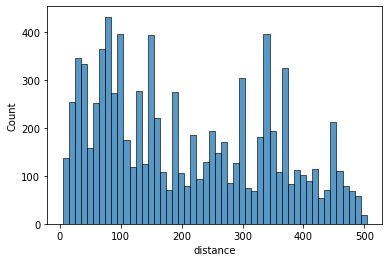

In [105]:
import seaborn as sn
sn.histplot(result, x = 'distance', binwidth = 10)

In [50]:
result2 = result[(result['distance'] < 100) & (result['distance'] > -100)]


<AxesSubplot:xlabel='distance', ylabel='Count'>

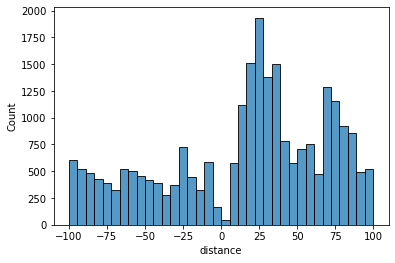

In [51]:
sn.histplot(result2, x = 'distance')

<AxesSubplot:>

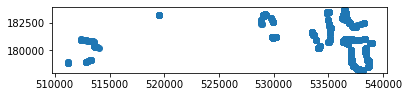

In [53]:
result[(result['distance'] < 30) & (result['distance'] > 0)].plot()

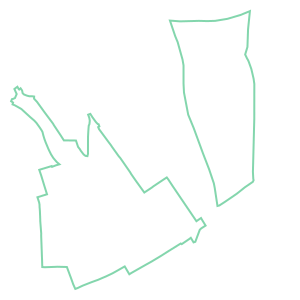

In [64]:
boundary

In [278]:
# # Filter data for year 2022 and convert to geodataframe
#sales_gdf = sales_gdf[sales_gdf["year"] > 2015]

# # Spatial join sales data with opportunity areas data
sales_gdf = gpd.sjoin(sales_gdf, oa_gdf, how="left", op="within", lsuffix="sales", rsuffix="oa")

# # Define treatment indicator variable
sales_gdf["treatment"] = sales_gdf["index_oa"].notnull().astype(int)

#mask = sales_gdf.geometry.intersects(boundary)

#sales_gdf_intersect = sales_gdf[mask]

#sales_gdf_intersect["distance"] = sales_gdf_intersect.geometry.apply(lambda x: np.sign(1 if x.within(boundary) else - 1) * boundary.distance(x))

#boundary = oa_gdf.boundary.unary_union # this returns a shapely geometry

sales_gdf["distance"] = sales_gdf.geometry.apply(lambda x: boundary.distance(x)) # this should work now

# # Define running variable as distance to nearest opportunity area boundary
#sales_gdf["distance"] = sales_gdf.geometry.apply(lambda x: np.sign(1 if x.within(boundary) else - 1) * boundary.distance(x))

#for p in sales_gdf:
#    if p.within(boundary)


/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.


In [280]:
sales_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 15831 entries, 1 to 47671
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   priceper                     15831 non-null  float64 
 1   year                         15831 non-null  int64   
 2   dateoftransfer               15831 non-null  object  
 3   propertytype                 15831 non-null  object  
 4   duration                     15831 non-null  object  
 5   price                        15831 non-null  int64   
 6   postcode                     15831 non-null  object  
 7   lad21cd                      15831 non-null  object  
 8   transactionid                15831 non-null  object  
 9   id                           15831 non-null  int64   
 10  tfarea                       15831 non-null  float64 
 11  numberrooms                  15831 non-null  float64 
 12  classt                       15831 non-null  int64  

Text(0.5, 1.0, 'Price per square metre by distance from OA boundary')

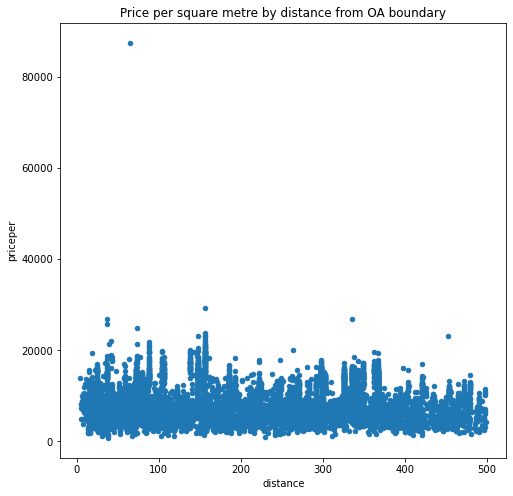

In [103]:
plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1)
result.plot.scatter(x="distance", y="priceper", ax=ax)
plt.title("Price per square metre by distance from OA boundary")


<AxesSubplot:xlabel='distance', ylabel='Count'>

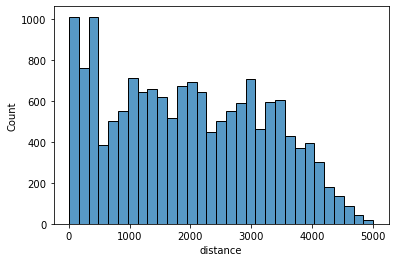

In [201]:
import seaborn as sn
sn.histplot(sales_gdf, x = 'distance')

In [153]:
# Spatial join sales data with opportunity areas data
sales_gdf = gpd.sjoin(sales_gdf, oa_gdf, how="left", op="within", lsuffix="sales", rsuffix="oa")
sales_gdf.info()

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
/tmp/ipykernel_1515/1977583316.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: PROJCS["unnamed",GEOGCS["Airy 1830",DATUM["unknown ...



<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 15831 entries, 1 to 47671
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   priceper                     15831 non-null  float64 
 1   year                         15831 non-null  int64   
 2   dateoftransfer               15831 non-null  object  
 3   propertytype                 15831 non-null  object  
 4   duration                     15831 non-null  object  
 5   price                        15831 non-null  int64   
 6   postcode                     15831 non-null  object  
 7   lad21cd                      15831 non-null  object  
 8   transactionid                15831 non-null  object  
 9   id                           15831 non-null  int64   
 10  tfarea                       15831 non-null  float64 
 11  numberrooms                  15831 non-null  float64 
 12  classt                       15831 non-null  int64  

In [154]:
import spreg as sp

# Load data

# # Filter data for year 2022 and convert to geodataframe
# sales_gdf = sales_gdf[sales_gdf["year"] > 2010]

# # Spatial join sales data with opportunity areas data
# sales_gdf = gpd.sjoin(sales_gdf, oa_gdf, how="left", op="within", lsuffix="sales", rsuffix="oa")

# Define treatment indicator variable
sales_gdf["treatment"] = sales_gdf["index_oa"].notnull().astype(int)

# Define running variable as distance to nearest opportunity area boundary
sales_gdf["distance"] = sales_gdf.geometry.apply(lambda x: oa_gdf.boundary.distance(x).min())

# Choose bandwidth using np.percentile
bw = np.percentile(sales_gdf["distance"], 10) # 10th percentile of distance as bandwidth

# Filter data for observations within bandwidth
sales_gdf = sales_gdf[sales_gdf["distance"].abs() <= bw]

# Define outcome variable as log of sales value
#sales_gdf["log_sales_value"] = np.log(sales_gdf["priceper"])

# Define explanatory variables as treatment indicator and distance
X = sales_gdf[["treatment", "distance"]].values


# Estimate spatial lag model using spreg.ML_Lag
model = sp.OLS(y=sales_gdf["priceper"].to_numpy()[:, None], x = sales_gdf["numberrooms"].to_numpy()[:, None])

# Print results
print(model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     dep_var                Number of Observations:        1593
Mean dependent var  :   9824.6134                Number of Variables   :           2
S.D. dependent var  :   4610.3526                Degrees of Freedom    :        1591
R-squared           :      0.0410
Adjusted R-squared  :      0.0404
Sum squared residual:32451324933.368                F-statistic           :     68.0103
Sigma-square        :20396810.140                Prob(F-statistic)     :   3.367e-16
S.E. of regression  :    4516.283                Log likelihood        :  -15665.172
Sigma-square ML     :20371202.093                Akaike info criterion :   31334.343
S.E of regression ML:   4513.4468                Schwarz criterion     :   31345.090

--------------------------------------------------------------------------

In [155]:
sales_gdf

priceper  year dateoftransfer propertytype duration    price  \
1047   10408.163265  2018     2018-11-16            F        L   510000   
2209    6219.765031  2013     2013-11-21            F        L   360000   
2224   12151.162791  2016     2016-03-31            T        F  1045000   
2294   12500.000000  2021     2021-12-17            T        L   675000   
2296   11620.370370  2016     2016-01-15            T        L   627500   
...             ...   ...            ...          ...      ...      ...   
45571  10396.975425  2012     2012-03-16            F        L   550000   
46833   9547.169811  2015     2015-08-28            F        L   506000   
46925   6353.135314  2011     2011-04-19            F        L   385000   
46932   9007.244958  2011     2011-05-19            F        L   460000   
46942  12926.829268  2019     2019-12-05            F        L   530000   

       postcode    lad21cd                           transactionid        id  \
1047    N1C 4AF  E09000007  {7E86B6FB-1CE7-458C-E053-6B04A8C0C84C}  19083867   
2209    NW1 0AA  E09000007  {9F60927C-8EC5-4E5F-B531-DB174E15E246}  19012301   
2224    NW1 0AB  E09000007  {34428D7E-503F-B86C-E050-A8C06205059C}  19002722   
2294    NW1 0BH  E09000007  {D707E535-A903-0AD9-E053-6B04A8C067CC}  19028874   
2296    NW1 0BH  E09000007  {2D1E4B26-9535-FCD1-E050-A8C0630544EC}  19028874   
...         ...        ...                                     ...       ...   
45571  WC1N 1JP  E09000007  {642D9101-E908-4C14-96A8-A908A29E03F1}  19049567   
46833  WC1X 8QP  E09000007  {25EA59F9-FE9D-4D50-E050-A8C0630562D0}  19048996   
46925  WC1X 9DB  E09000007  {A6999999-76AC-4A35-AAF7-6A4FB7C00E7A}  19024202   
46932  WC1X 9DB  E09000007  {962AD011-A95D-4D4C-B299-AC71969F2ABC}  19040636   
46942  WC1X 9JH  E09000007  {9DBAD222-0374-6EB3-E053-6B04A8C0F257}  19041700   

       ...  planning_authority  removeddate                   sitename  \
1047   ...                             None  King's Cross - St Pancras   
2209   ...                 NaN          NaN                        NaN   
2224   ...                 NaN          NaN                        NaN   
2294   ...                 NaN          NaN                        NaN   
2296   ...                 NaN          NaN                        NaN   
...    ...                 ...          ...                        ...   
45571  ...                 NaN          NaN                        NaN   
46833  ...                 NaN          NaN                        NaN   
46925  ...                 NaN          NaN                        NaN   
46932  ...                 NaN          NaN                        NaN   
46942  ...                 NaN          NaN                        NaN   

       sitereference              source   status  uprn_oa     runtime  \
1047              19  Planning Framework  Adopted     None  09/18/2019   
2209             NaN                 NaN      NaN      NaN         NaN   
2224             NaN                 NaN      NaN      NaN         NaN   
2294             NaN                 NaN      NaN      NaN         NaN   
2296             NaN                 NaN      NaN      NaN         NaN   
...              ...                 ...      ...      ...         ...   
45571            NaN                 NaN      NaN      NaN         NaN   
46833            NaN                 NaN      NaN      NaN         NaN   
46925            NaN                 NaN      NaN      NaN         NaN   
46932            NaN                 NaN      NaN      NaN         NaN   
46942            NaN                 NaN      NaN      NaN         NaN   

       treatment    distance  
1047           1   36.586836  
2209           0  130.497234  
2224           0  245.971769  
2294           0  266.710141  
2296           0  266.710141  
...          ...         ...  
45571          0  278.229190  
46833          0  162.102690  
46925          0  276.189832  
46932          0  234.819186  
46942          0  234.440707  

In [ ]:
# # Filter data for year 2022 and convert to geodataframe
sales_gdf = sales_gdf[sales_gdf["year"] > 2015]

# # Spatial join sales data with opportunity areas data
sales_gdf = gpd.sjoin(sales_gdf, oa_gdf, how="left", op="within", lsuffix="sales", rsuffix="oa")

# # Define treatment indicator variable
sales_gdf["treatment"] = sales_gdf["index_oa"].notnull().astype(int)

# # Define running variable as distance to nearest opportunity area boundary
sales_gdf["distance"] = sales_gdf.geometry.apply(lambda x: oa_gdf.boundary.distance(x).min())

# # Choose bandwidth using rdrobust.bandwidth
bw = rd.rdrobust(sales_gdf["priceper"], sales_gdf["distance"], sales_gdf["treatment"]).bandwidth

# # Filter data for observations within bandwidth
sales_gdf = sales_gdf[sales_gdf["distance"].abs() <= bw]

# # Estimate effect using rdrobust
rd_result = rd.rdrobust(sales_gdf["priceper"], sales_gdf["distance"], sales_gdf["treatment"])
# # Print results
print(rd_result.summary)

# # Plot results
rd.plot(rd_result)
plt.show()


In [ ]:
sales_gdf